In [ ]:
#-----------------------------------------
# Title:  Random Forest San Francisco Crime Classification Dataset
# Subtitle: DDS-8555, Assignment 8
# Author: Madgene Moise
# Date: Sunday, July 6, 2025
#-----------------------------------------

In [1]:
import pandas as pd

# Load the training and testing datasets

train_df = pd.read_csv("/kaggle/input/sf-crime/train.csv.zip") 
test_df = pd.read_csv("/kaggle/input/sf-crime/test.csv.zip")

# Display the first few rows of each dataset to understand structure
train_head = train_df.head()
test_head = test_df.head()

train_df.shape, test_df.shape, train_head, test_head

((878049, 9),
 (884262, 7),
                  Dates        Category                      Descript  \
 0  2015-05-13 23:53:00        WARRANTS                WARRANT ARREST   
 1  2015-05-13 23:53:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
 2  2015-05-13 23:33:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
 3  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   
 4  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   
 
    DayOfWeek PdDistrict      Resolution                    Address  \
 0  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
 1  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
 2  Wednesday   NORTHERN  ARREST, BOOKED  VANNESS AV / GREENWICH ST   
 3  Wednesday   NORTHERN            NONE   1500 Block of LOMBARD ST   
 4  Wednesday       PARK            NONE  100 Block of BRODERICK ST   
 
             X          Y  
 0 -122.425892  37.774599  
 1 -122.425892  37.774599  
 2 -122.424363  37.8

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import os


In [3]:
# === FEATURE ENGINEERING ===
def preprocess(df, is_train=True):
    df = df.copy()
    df["Dates"] = pd.to_datetime(df["Dates"])
    df["Year"] = df["Dates"].dt.year
    df["Month"] = df["Dates"].dt.month
    df["Day"] = df["Dates"].dt.day
    df["Hour"] = df["Dates"].dt.hour
    df["Minute"] = df["Dates"].dt.minute
    df.drop(columns=["Dates", "Address"], inplace=True)

    df["DayOfWeek"] = LabelEncoder().fit_transform(df["DayOfWeek"])
    df["PdDistrict"] = LabelEncoder().fit_transform(df["PdDistrict"])

    if is_train:
        y = df["Category"]
        df.drop(columns=["Category", "Descript", "Resolution"], inplace=True)
        return df, y
    else:
        ids = df["Id"]
        df.drop(columns=["Id"], inplace=True)
        return df, ids

print("Preprocessing data...")
X_full, y_raw = preprocess(train_df, is_train=True)
X_test, test_ids = preprocess(test_df, is_train=False)

Preprocessing data...


In [5]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)

# === CONFIGURATION ===
SAMPLE_PERCENTAGE = 0.10  # 10% stratified sample for training

# === STRATIFIED SAMPLING ===
print(f"Sampling {int(SAMPLE_PERCENTAGE * 100)}% of training data...")
sss = StratifiedShuffleSplit(n_splits=1, test_size=SAMPLE_PERCENTAGE, random_state=42)
sample_idx, _ = next(sss.split(X_full, y))
X = X_full.iloc[sample_idx]
y = y[sample_idx]

# === TRAIN-VALIDATION SPLIT ===
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === MODEL TRAINING ===
print("Training Random Forest model...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

Sampling 10% of training data...
Training Random Forest model...


RandomForestClassifier(n_jobs=-1, random_state=42)

In [6]:
# === CONFIGURATION ===
SUBMISSION_PATH = "/kaggle/working/rf_submission_moisem.csv"

# === VALIDATION ===
print("Evaluating model...")
y_pred = rf.predict(X_val)
report = classification_report(y_val, y_pred, target_names=label_encoder.classes_)
print("\nClassification Report:\n")
print(report)

# === FINAL TRAINING ON FULL SAMPLE ===
print("Retraining on full sampled training data...")
rf.fit(X, y)

# === PREDICT TEST SET ===
print("Predicting test set probabilities...")
probs = rf.predict_proba(X_test)

# === FORMAT SUBMISSION ===
print("Generating submission file...")
submission_df = pd.DataFrame(probs, columns=label_encoder.classes_)
submission_df.insert(0, "Id", test_ids)
submission_df.to_csv(SUBMISSION_PATH, index=False)
print(f"Submission file saved to: {SUBMISSION_PATH}")

Evaluating model...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:

                             precision    recall  f1-score   support

                      ARSON       0.10      0.02      0.04       272
                    ASSAULT       0.23      0.20      0.21     13838
                 BAD CHECKS       0.00      0.00      0.00        73
                    BRIBERY       0.00      0.00      0.00        52
                   BURGLARY       0.17      0.07      0.10      6616
         DISORDERLY CONDUCT       0.04      0.03      0.03       778
DRIVING UNDER THE INFLUENCE       0.05      0.02      0.03       408
              DRUG/NARCOTIC       0.37      0.43      0.40      9715
                DRUNKENNESS       0.00      0.00      0.00       770
               EMBEZZLEMENT       0.01      0.00      0.01       210
                  EXTORTION       0.00      0.00      0.00        46
            FAMILY OFFENSES       0.18      0.07      0.10        88
     FORGERY/COUNTERFEITING       0.19      0.09      0.12      1910
        

**Global Performance Metrics**

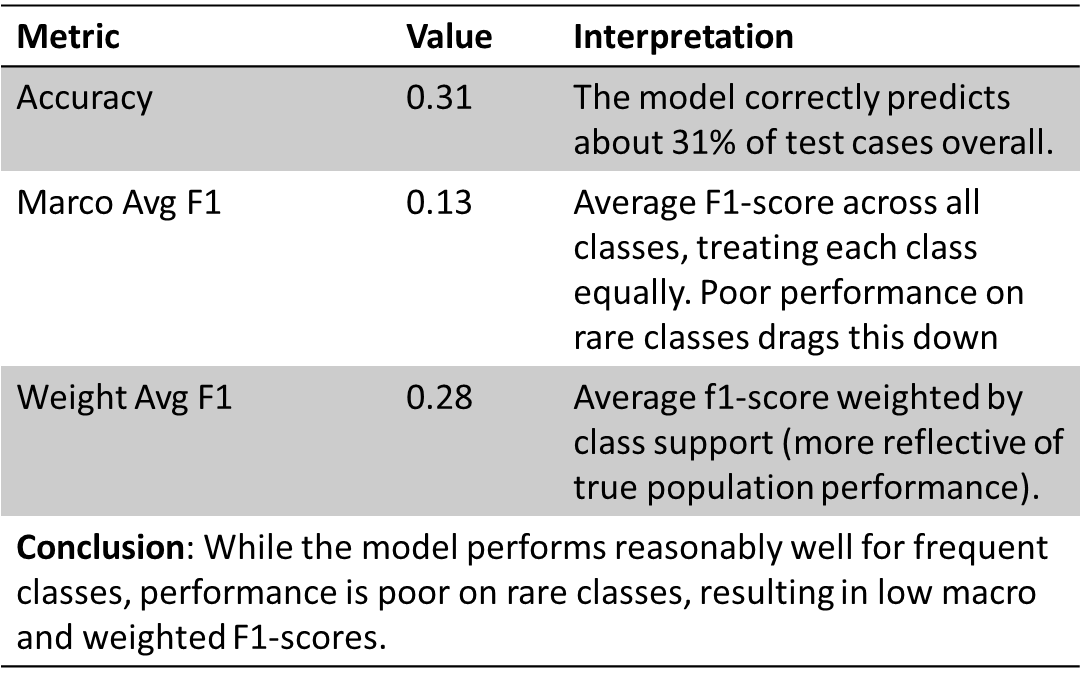

**Best Performing Classes**

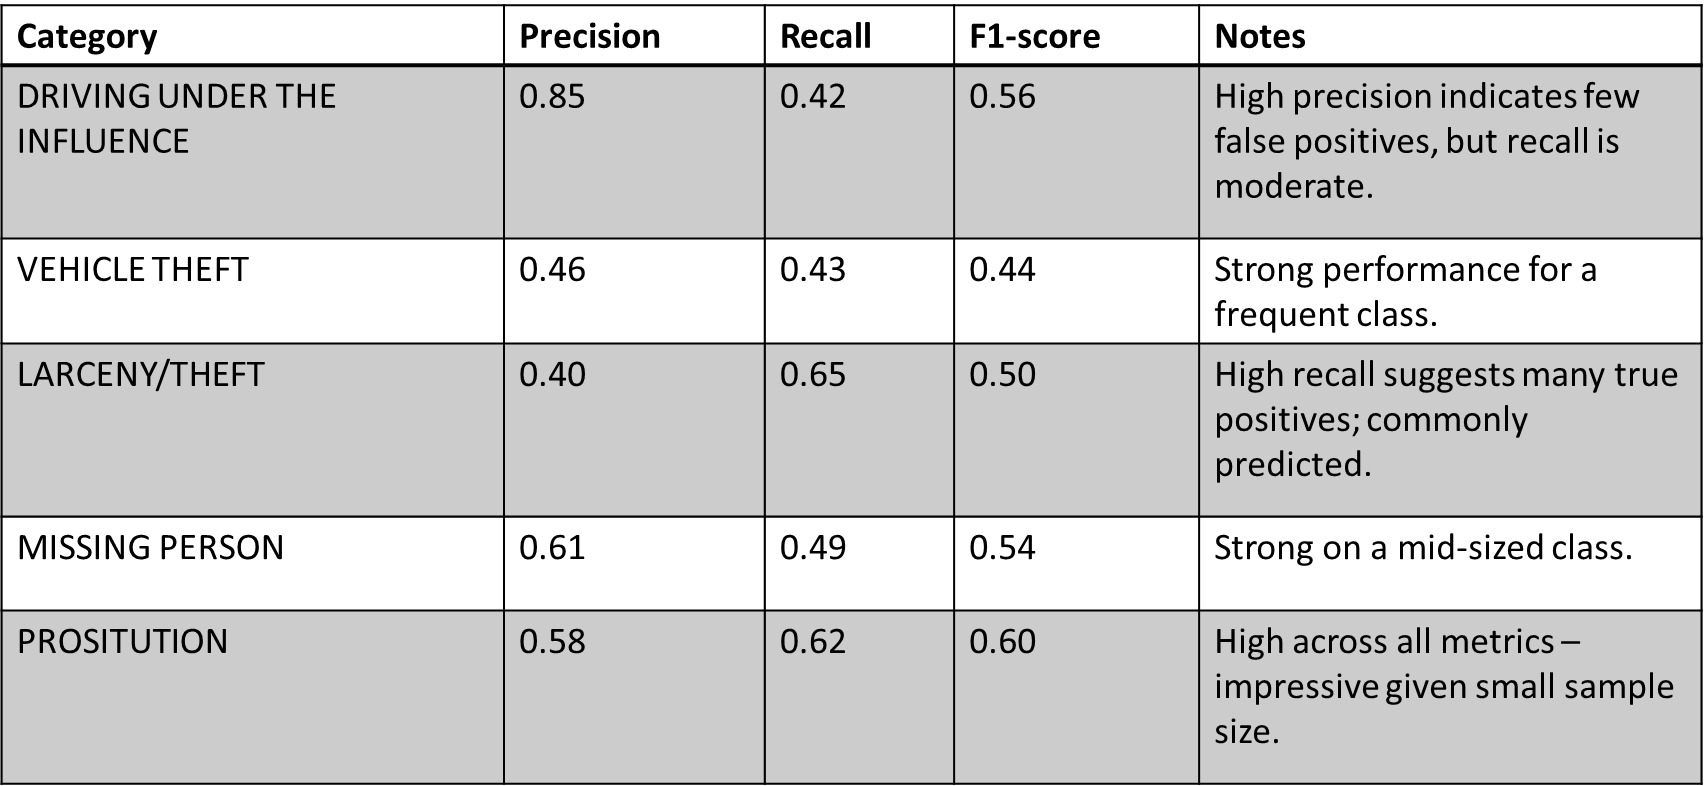

**Worst Performing Classes**

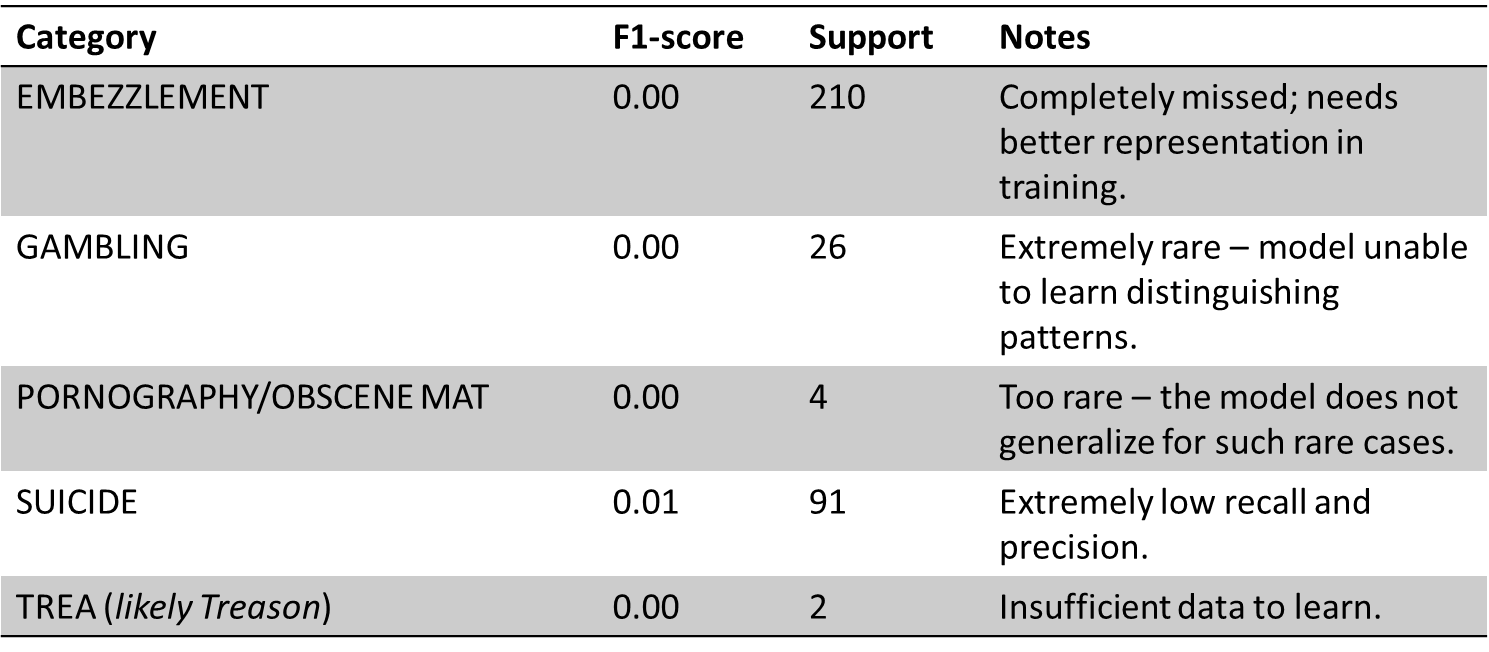

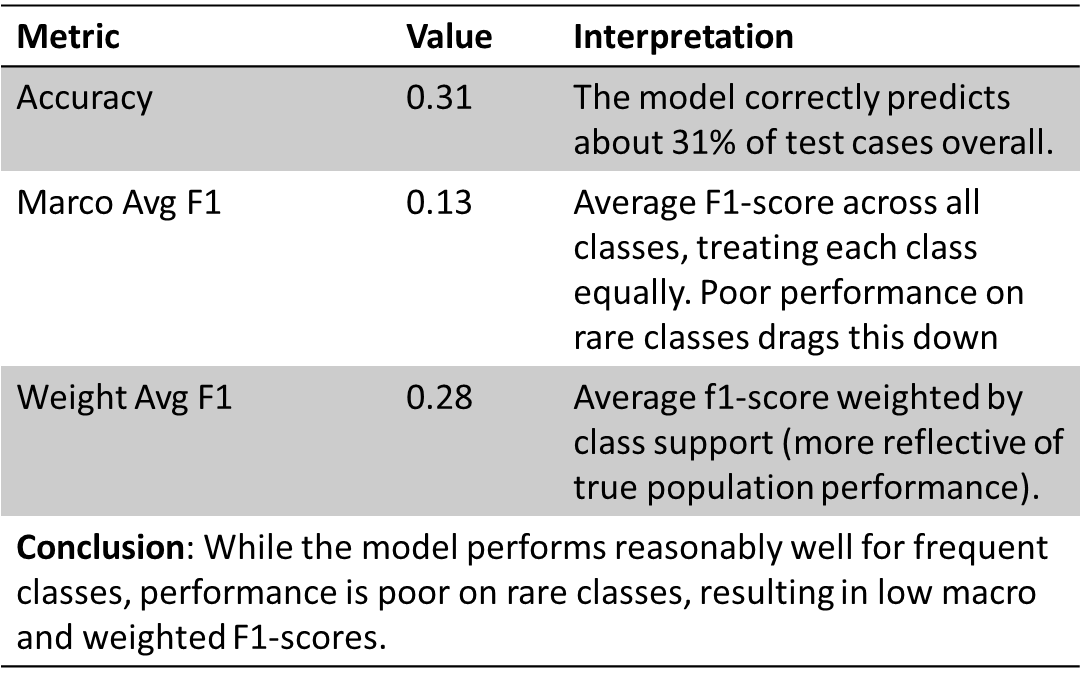
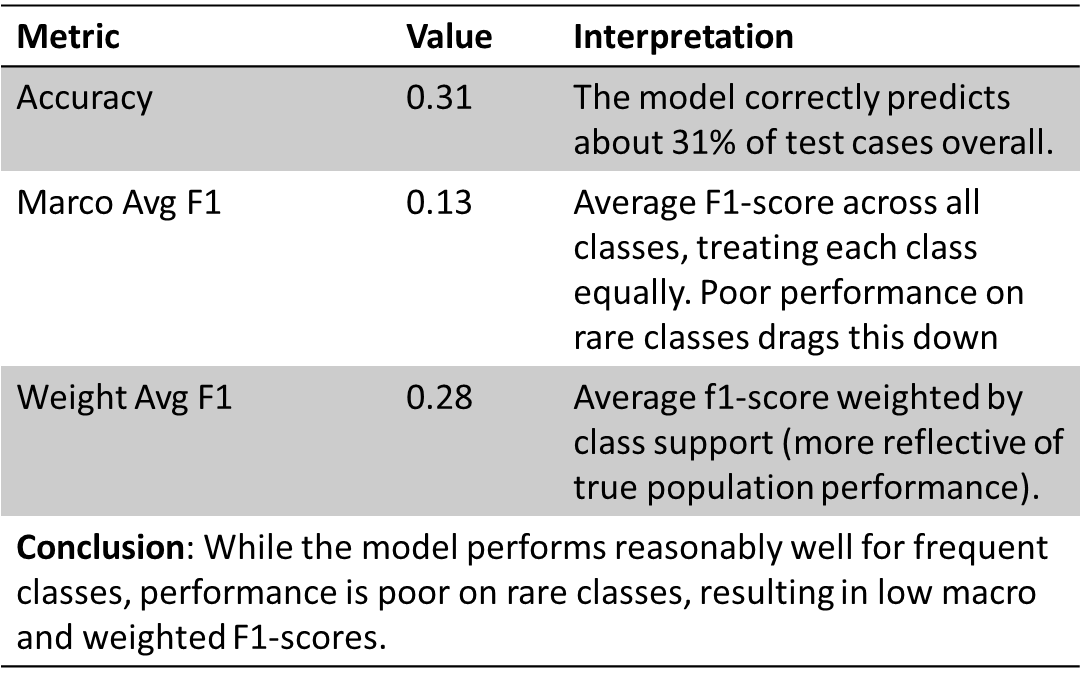
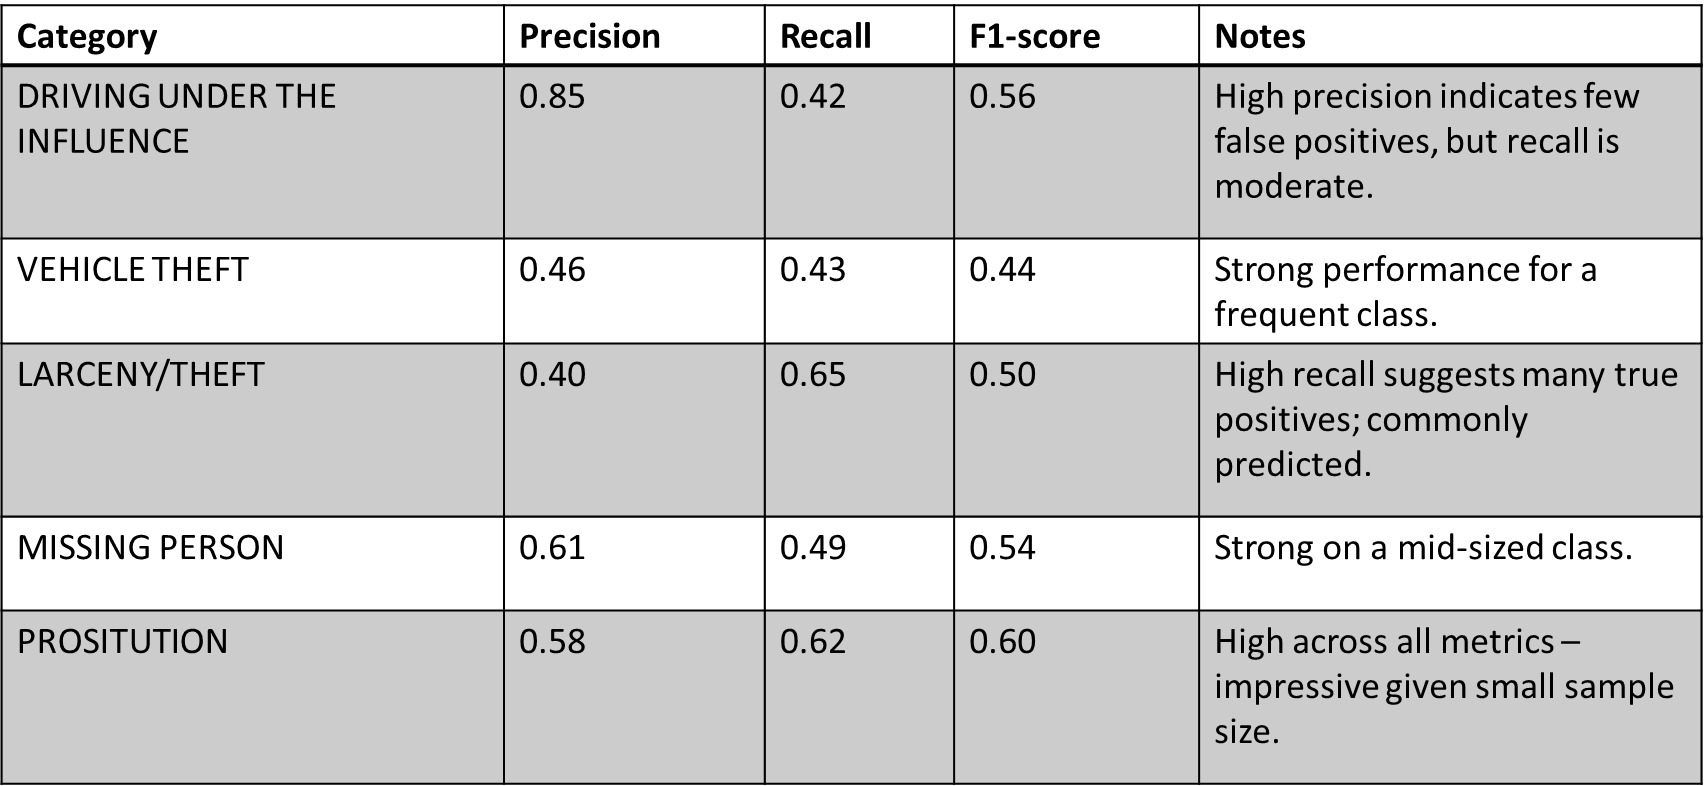
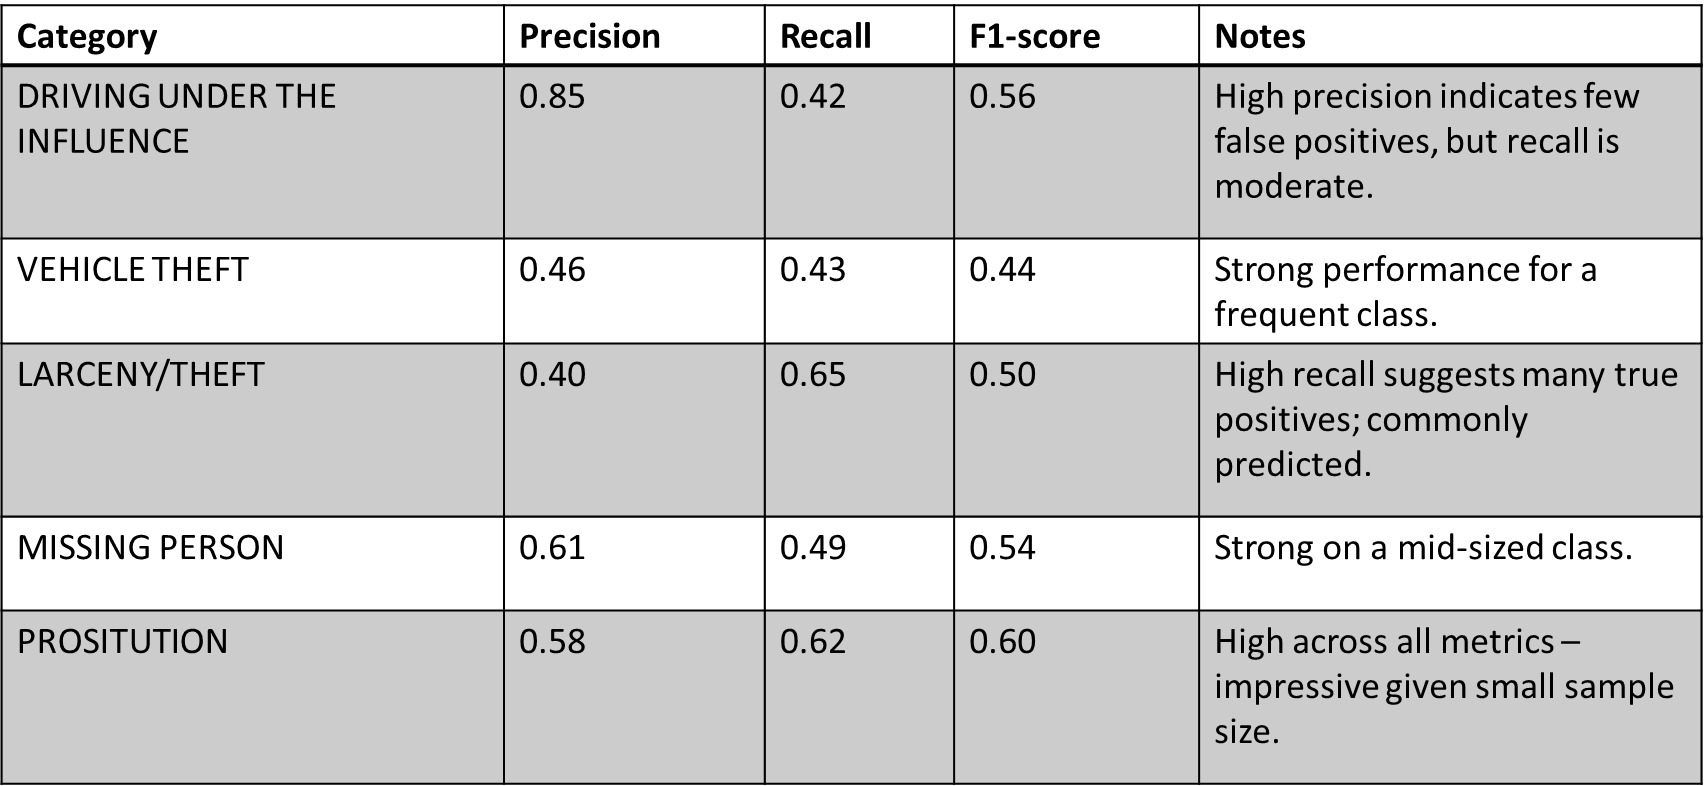
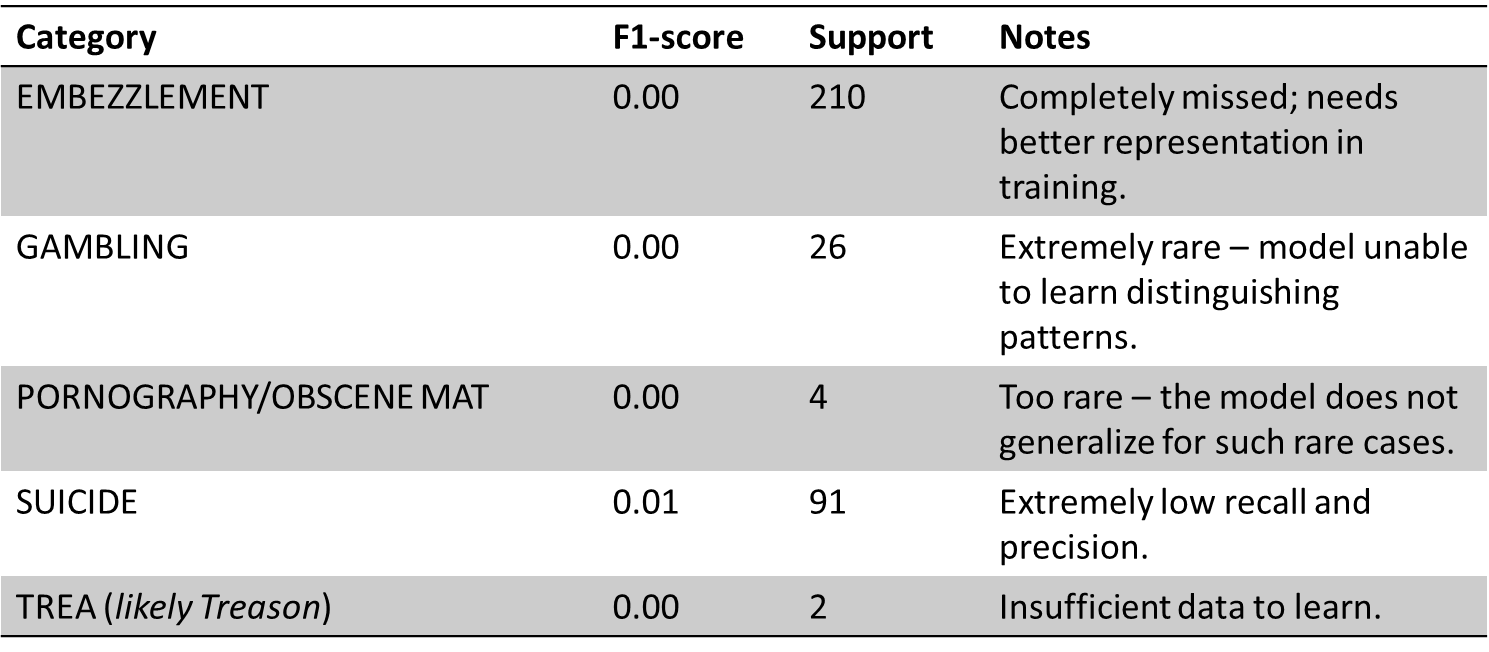
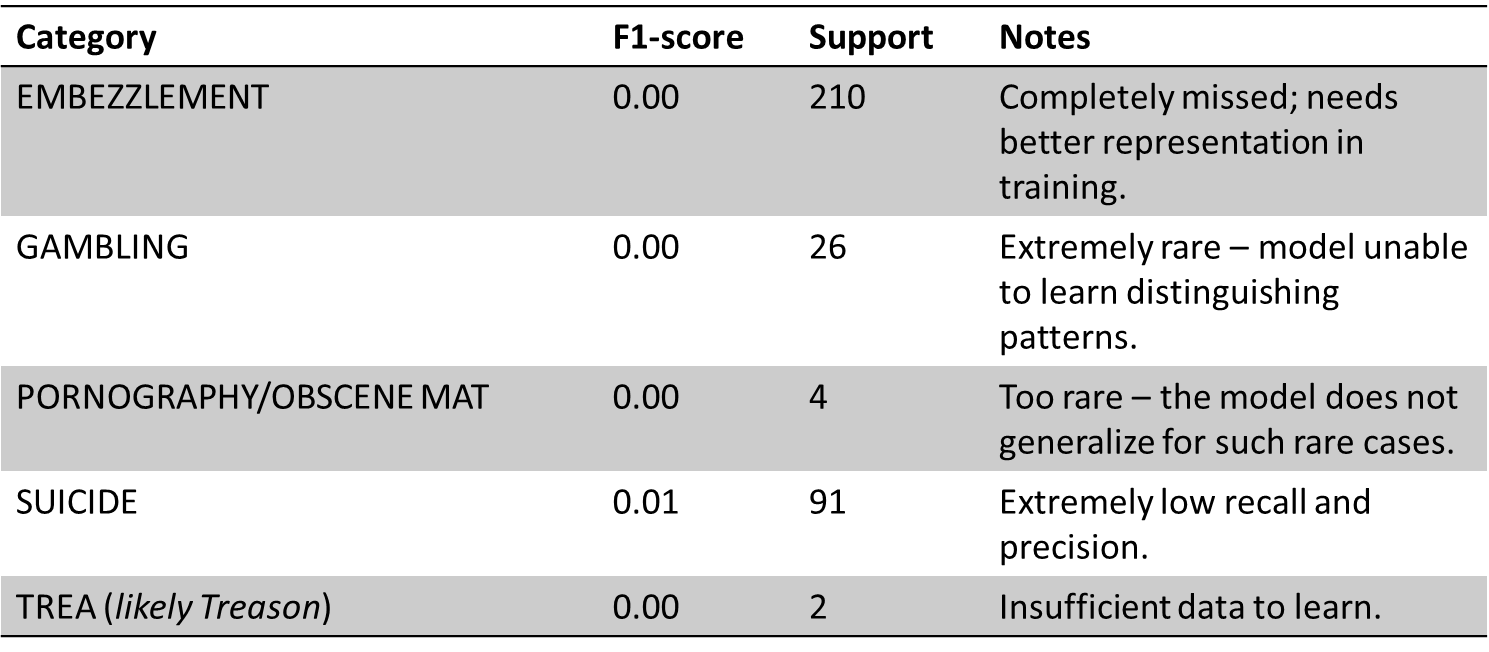